In [21]:
import pandas as pd
import numpy as np
import os
import json
from scipy.stats import spearmanr, pearsonr

In [22]:
CHOSEN_MODEL="Qwen2.5-Math-1.5B"

In [3]:
PROBE_PREDICTIONS_DATA_PATH = f"../runs/{CHOSEN_MODEL}/generate_svs/predicting_learnability/best_probe_predictions.json"

In [4]:
with open(PROBE_PREDICTIONS_DATA_PATH, 'r') as f:
    probe_data = json.load(f)

In [5]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [6]:
train_gt, test_gt, train_preds, test_preds = probe_data["train_actual"], probe_data["test_actual"], probe_data["train_predictions"], probe_data["test_predictions"]

In [7]:
train_analysis_df = pd.DataFrame({
    "gt": train_gt,
    "preds": train_preds,
    "preds_sigmoid": sigmoid(np.array(train_preds))
})
test_analysis_df = pd.DataFrame({
    "gt": test_gt,
    "preds": test_preds,
    "preds_sigmoid": sigmoid(np.array(test_preds))

})

In [8]:
train_analysis_df.head()

,gt,preds,preds_sigmoid
0,1.00,1.026175,0.736174
1,1.00,1.019198,0.734816
2,0.00,0.359128,0.588829
3,1.00,0.858298,0.702305
4,0.06,0.001518,0.500379


In [9]:
test_analysis_df.head()

,gt,preds,preds_sigmoid
0,0.00,0.174451,0.543503
1,0.96,0.448752,0.610342
2,1.00,1.027840,0.736497
3,1.00,1.277921,0.782096
4,0.00,0.254391,0.563257


<Axes: >

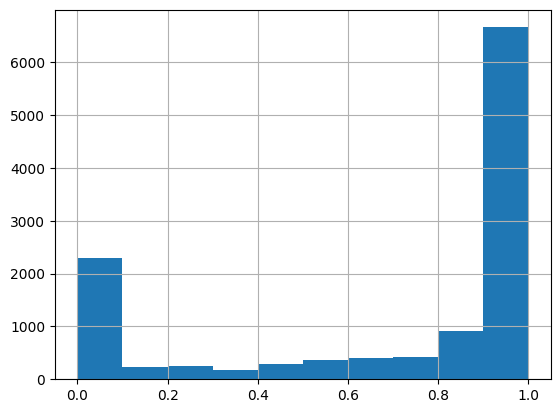

In [10]:
train_analysis_df["gt"].hist()

<Axes: >

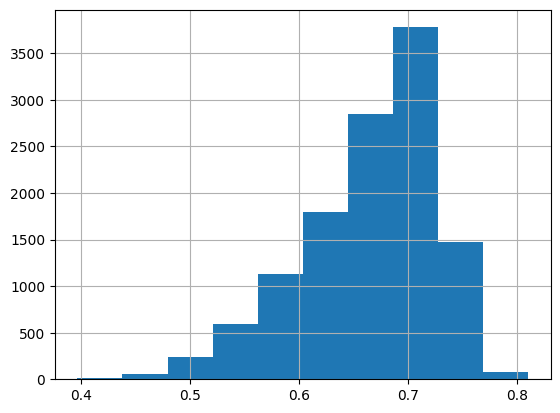

In [11]:
train_analysis_df["preds_sigmoid"].hist()

<Axes: >

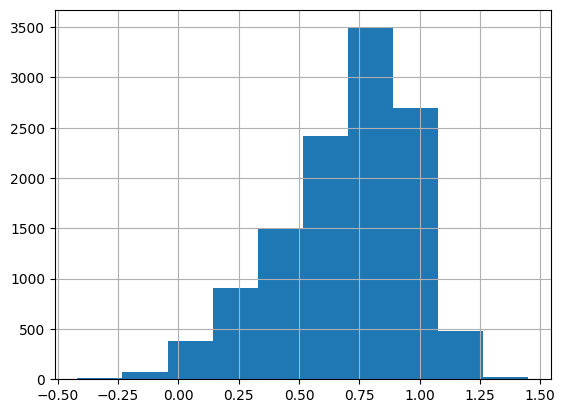

In [12]:
train_analysis_df["preds"].hist()

In [13]:
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report

# Check the nature of ground truth values
print("Ground truth value range:")
print(f"Train gt - min: {train_analysis_df['gt'].min():.4f}, max: {train_analysis_df['gt'].max():.4f}")
print(f"Test gt - min: {test_analysis_df['gt'].min():.4f}, max: {test_analysis_df['gt'].max():.4f}")
print(f"Unique train gt values: {train_analysis_df['gt'].nunique()}")

# MSE using RAW predictions (no sigmoid) - better since probe outputs aren't bounded
train_mse_raw = mean_squared_error(train_analysis_df["gt"], train_analysis_df["preds"])
test_mse_raw = mean_squared_error(test_analysis_df["gt"], test_analysis_df["preds"])

print(f"\nMSE (raw predictions):")
print(f"Train MSE: {train_mse_raw:.4f}")
print(f"Test MSE: {test_mse_raw:.4f}")

# MSE using sigmoid predictions for comparison
train_mse_sigmoid = mean_squared_error(train_analysis_df["gt"], train_analysis_df["preds_sigmoid"])
test_mse_sigmoid = mean_squared_error(test_analysis_df["gt"], test_analysis_df["preds_sigmoid"])

print(f"\nMSE (sigmoid predictions):")
print(f"Train MSE: {train_mse_sigmoid:.4f}")
print(f"Test MSE: {test_mse_sigmoid:.4f}")

# If gt values are truly binary (0 or 1), we can do classification metrics
# First convert gt to int if they are 0.0/1.0 floats
if set(train_analysis_df["gt"].unique()).issubset({0, 1, 0.0, 1.0}):
    train_gt_binary = train_analysis_df["gt"].astype(int)
    test_gt_binary = test_analysis_df["gt"].astype(int)
    
    # Binary predictions using threshold on raw predictions (threshold at 0.5 or median)
    threshold = 0.5
    train_preds_binary = (train_analysis_df["preds_sigmoid"] >= threshold).astype(int)
    test_preds_binary = (test_analysis_df["preds_sigmoid"] >= threshold).astype(int)
    
    train_acc = accuracy_score(train_gt_binary, train_preds_binary)
    test_acc = accuracy_score(test_gt_binary, test_preds_binary)
    
    print(f"\nClassification Metrics (threshold={threshold}):")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    
    print("\n--- Train Classification Report ---")
    print(classification_report(train_gt_binary, train_preds_binary))
    
    print("--- Test Classification Report ---")
    print(classification_report(test_gt_binary, test_preds_binary))
else:
    print("\nGround truth is continuous - classification metrics not applicable")

Ground truth value range:
Train gt - min: 0.0000, max: 1.0000
Test gt - min: 0.0000, max: 1.0000
Unique train gt values: 51

MSE (raw predictions):
Train MSE: 0.0768
Test MSE: 0.1015

MSE (sigmoid predictions):
Train MSE: 0.1223
Test MSE: 0.1268

Ground truth is continuous - classification metrics not applicable


In [14]:
# =============================================================================
# ANALYSIS: Binned Classification for Success Rate Prediction
# =============================================================================
# Goal: Evaluate how well the probe predicts difficulty categories
# 0 = Very Hard (low success rate), 1 = Very Easy (high success rate)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define bins: [0, 0.2) = Very Hard, [0.2, 0.4) = Hard, [0.4, 0.6) = Medium, 
#              [0.6, 0.8) = Easy, [0.8, 1.0] = Very Easy
bin_edges = [0, 0.2, 0.4, 0.6, 0.8, 1.01]  # 1.01 to include 1.0
bin_labels = ['Very Hard\n(0-0.2)', 'Hard\n(0.2-0.4)', 'Medium\n(0.4-0.6)', 
              'Easy\n(0.6-0.8)', 'Very Easy\n(0.8-1.0)']

# Bin the ground truth and predictions
train_gt_binned = pd.cut(train_analysis_df["gt"], bins=bin_edges, labels=bin_labels, include_lowest=True)
test_gt_binned = pd.cut(test_analysis_df["gt"], bins=bin_edges, labels=bin_labels, include_lowest=True)

# Clip raw predictions to [0, 1] before binning (since they can be outside this range)
train_preds_clipped = np.clip(train_analysis_df["preds"], 0, 1)
test_preds_clipped = np.clip(test_analysis_df["preds"], 0, 1)

train_preds_binned = pd.cut(train_preds_clipped, bins=bin_edges, labels=bin_labels, include_lowest=True)
test_preds_binned = pd.cut(test_preds_clipped, bins=bin_edges, labels=bin_labels, include_lowest=True)

print("=" * 60)
print("BINNED CLASSIFICATION ANALYSIS (5 Classes)")
print("=" * 60)

# Distribution of ground truth bins
print("\nGround Truth Distribution:")
print("Train:")
print(train_gt_binned.value_counts().sort_index())
print("\nTest:")
print(test_gt_binned.value_counts().sort_index())

# Accuracy
train_bin_acc = (train_gt_binned == train_preds_binned).mean()
test_bin_acc = (test_gt_binned == test_preds_binned).mean()

print(f"\n5-Class Binned Accuracy:")
print(f"Train: {train_bin_acc:.4f}")
print(f"Test: {test_bin_acc:.4f}")

# Classification report
print("\n--- Train Classification Report (Binned) ---")
print(classification_report(train_gt_binned, train_preds_binned, zero_division=0))

print("--- Test Classification Report (Binned) ---")
print(classification_report(test_gt_binned, test_preds_binned, zero_division=0))

BINNED CLASSIFICATION ANALYSIS (5 Classes)

Ground Truth Distribution:
Train:
gt
Very Hard\n(0-0.2)      2579
Hard\n(0.2-0.4)          446
Medium\n(0.4-0.6)        589
Easy\n(0.6-0.8)          950
Very Easy\n(0.8-1.0)    7436
Name: count, dtype: int64

Test:
gt
Very Hard\n(0-0.2)      110
Hard\n(0.2-0.4)          20
Medium\n(0.4-0.6)        23
Easy\n(0.6-0.8)          48
Very Easy\n(0.8-1.0)    299
Name: count, dtype: int64

5-Class Binned Accuracy:
Train: 0.4858
Test: 0.4100

--- Train Classification Report (Binned) ---
                     precision    recall  f1-score   support

     Easy
(0.6-0.8)       0.12      0.39      0.18       950
     Hard
(0.2-0.4)       0.09      0.24      0.13       446
   Medium
(0.4-0.6)       0.10      0.34      0.16       589
Very Easy
(0.8-1.0)       0.91      0.61      0.73      7436
  Very Hard
(0-0.2)       0.87      0.23      0.37      2579

           accuracy                           0.49     12000
          macro avg       0.42      0.36    

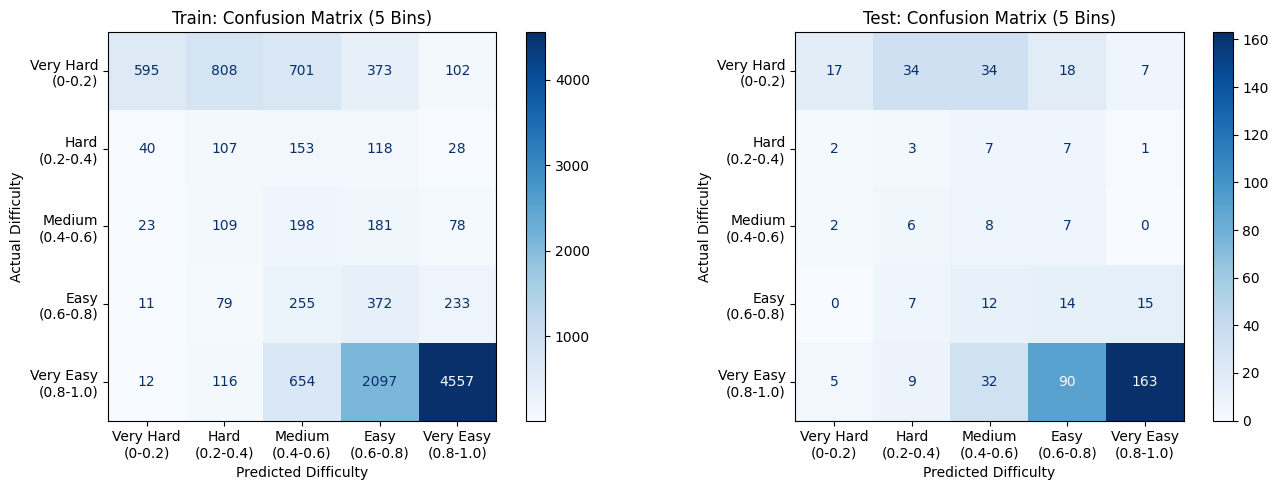

In [15]:
# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train confusion matrix
cm_train = confusion_matrix(train_gt_binned, train_preds_binned, labels=bin_labels)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=bin_labels)
disp_train.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Train: Confusion Matrix (5 Bins)')
axes[0].set_xlabel('Predicted Difficulty')
axes[0].set_ylabel('Actual Difficulty')

# Test confusion matrix
cm_test = confusion_matrix(test_gt_binned, test_preds_binned, labels=bin_labels)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=bin_labels)
disp_test.plot(ax=axes[1], cmap='Blues', values_format='d')
axes[1].set_title('Test: Confusion Matrix (5 Bins)')
axes[1].set_xlabel('Predicted Difficulty')
axes[1].set_ylabel('Actual Difficulty')

plt.tight_layout()
plt.show()

In [16]:
# =============================================================================
# FOCUSED ANALYSIS: Extremes Only (Very Hard vs Very Easy)
# =============================================================================
# This is what you care about most: can the model distinguish 
# really easy (success rate >= 0.8) from really hard (success rate <= 0.2)?

print("=" * 60)
print(f"EXTREME DIFFICULTY ANALYSIS {CHOSEN_MODEL} (Very Hard vs Very Easy)")
print("=" * 60)

# Filter to only extreme cases in ground truth
train_extreme_mask = (train_analysis_df["gt"] <= 0.2) | (train_analysis_df["gt"] >= 0.8)
test_extreme_mask = (test_analysis_df["gt"] <= 0.2) | (test_analysis_df["gt"] >= 0.8)

print(f"\nSamples with extreme difficulty:")
print(f"Train: {train_extreme_mask.sum()} / {len(train_analysis_df)} ({100*train_extreme_mask.mean():.1f}%)")
print(f"Test: {test_extreme_mask.sum()} / {len(test_analysis_df)} ({100*test_extreme_mask.mean():.1f}%)")

# Create binary labels: 0 = Very Hard (<=0.2), 1 = Very Easy (>=0.8)
train_extreme_gt = (train_analysis_df.loc[train_extreme_mask, "gt"] >= 0.8).astype(int)
test_extreme_gt = (test_analysis_df.loc[test_extreme_mask, "gt"] >= 0.8).astype(int)

# Predictions: threshold at 0.5 on raw predictions
train_extreme_preds = (train_analysis_df.loc[train_extreme_mask, "preds"] >= 0.5).astype(int)
test_extreme_preds = (test_analysis_df.loc[test_extreme_mask, "preds"] >= 0.5).astype(int)

if train_extreme_mask.sum() > 0:
    train_extreme_acc = accuracy_score(train_extreme_gt, train_extreme_preds)
    test_extreme_acc = accuracy_score(test_extreme_gt, test_extreme_preds)
    
    print(f"\nBinary Accuracy (Very Hard=0 vs Very Easy=1):")
    print(f"Train: {train_extreme_acc:.4f}")
    print(f"Test: {test_extreme_acc:.4f}")
    
    print("\n--- Train: Extreme Cases Classification Report ---")
    print(classification_report(train_extreme_gt, train_extreme_preds, 
                                target_names=['Very Hard (≤0.2)', 'Very Easy (≥0.8)'], zero_division=0))
    
    print("--- Test: Extreme Cases Classification Report ---")
    print(classification_report(test_extreme_gt, test_extreme_preds,
                                target_names=['Very Hard (≤0.2)', 'Very Easy (≥0.8)'], zero_division=0))

EXTREME DIFFICULTY ANALYSIS Qwen2.5-Math-1.5B (Very Hard vs Very Easy)

Samples with extreme difficulty:
Train: 10144 / 12000 (84.5%)
Test: 412 / 500 (82.4%)

Binary Accuracy (Very Hard=0 vs Very Easy=1):
Train: 0.8837
Test: 0.8422

--- Train: Extreme Cases Classification Report ---
                  precision    recall  f1-score   support

Very Hard (≤0.2)       0.83      0.68      0.75      2579
Very Easy (≥0.8)       0.90      0.95      0.92      7565

        accuracy                           0.88     10144
       macro avg       0.86      0.82      0.84     10144
    weighted avg       0.88      0.88      0.88     10144

--- Test: Extreme Cases Classification Report ---
                  precision    recall  f1-score   support

Very Hard (≤0.2)       0.73      0.65      0.69       110
Very Easy (≥0.8)       0.88      0.91      0.89       302

        accuracy                           0.84       412
       macro avg       0.80      0.78      0.79       412
    weighted avg       

In [17]:
# ============================================================
# EXTREME DIFFICULTY ANALYSIS (Very Hard vs Very Easy)
# ============================================================

# Samples with extreme difficulty:
# Train: 7050 / 11999 (58.8%)
# Test: 312 / 500 (62.4%)

# Binary Accuracy (Very Hard=0 vs Very Easy=1):
# Train: 0.9474
# Test: 0.9071

# --- Train: Extreme Cases Classification Report ---
#                   precision    recall  f1-score   support

# Very Hard (≤0.2)       0.97      0.96      0.96      5203
# Very Easy (≥0.8)       0.90      0.90      0.90      1847

#         accuracy                           0.95      7050
#        macro avg       0.93      0.93      0.93      7050
#     weighted avg       0.95      0.95      0.95      7050

# --- Test: Extreme Cases Classification Report ---
#                   precision    recall  f1-score   support

# Very Hard (≤0.2)       0.94      0.94      0.94       243
# Very Easy (≥0.8)       0.79      0.80      0.79        69

#         accuracy                           0.91       312
#        macro avg       0.86      0.87      0.87       312
#     weighted avg       0.91      0.91      0.91       312



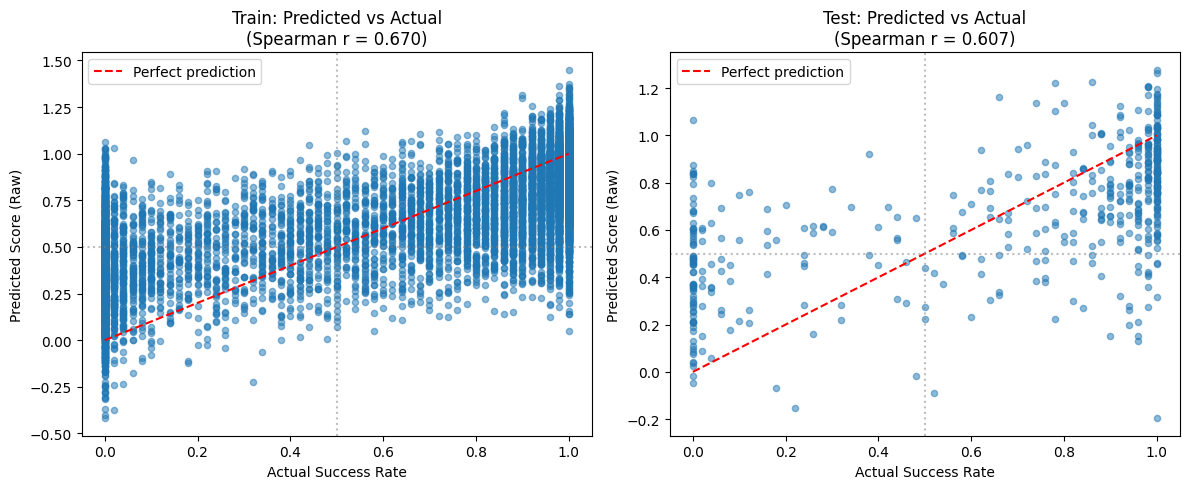


Correlation Summary:
Train Spearman: 0.6696
Test Spearman: 0.6070
Train Pearson: 0.7015
Test Pearson: 0.5868


In [18]:
# =============================================================================
# SCATTER PLOT: Predictions vs Actual
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Train scatter
axes[0].scatter(train_analysis_df["gt"], train_analysis_df["preds"], alpha=0.5, s=20)
axes[0].plot([0, 1], [0, 1], 'r--', label='Perfect prediction')
axes[0].axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
axes[0].axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)
axes[0].set_xlabel('Actual Success Rate')
axes[0].set_ylabel('Predicted Score (Raw)')
axes[0].set_title(f'Train: Predicted vs Actual\n(Spearman r = {spearmanr(train_analysis_df["gt"], train_analysis_df["preds"])[0]:.3f})')
axes[0].legend()

# Test scatter
axes[1].scatter(test_analysis_df["gt"], test_analysis_df["preds"], alpha=0.5, s=20)
axes[1].plot([0, 1], [0, 1], 'r--', label='Perfect prediction')
axes[1].axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
axes[1].axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)
axes[1].set_xlabel('Actual Success Rate')
axes[1].set_ylabel('Predicted Score (Raw)')
axes[1].set_title(f'Test: Predicted vs Actual\n(Spearman r = {spearmanr(test_analysis_df["gt"], test_analysis_df["preds"])[0]:.3f})')
axes[1].legend()

plt.tight_layout()
plt.show()

# Print correlation summary
print("\nCorrelation Summary:")
print(f"Train Spearman: {spearmanr(train_analysis_df['gt'], train_analysis_df['preds'])[0]:.4f}")
print(f"Test Spearman: {spearmanr(test_analysis_df['gt'], test_analysis_df['preds'])[0]:.4f}")
print(f"Train Pearson: {pearsonr(train_analysis_df['gt'], train_analysis_df['preds'])[0]:.4f}")
print(f"Test Pearson: {pearsonr(test_analysis_df['gt'], test_analysis_df['preds'])[0]:.4f}")

In [19]:
len(test_analysis_df[test_analysis_df["preds"] <= 0.0])

7

In [20]:
# =============================================================================
# FOCUSED ANALYSIS: Extremes Only (Very Hard vs Very Easy)
# =============================================================================
# This is what you care about most: can the model distinguish 
# really easy (success rate >= .9) from really hard (success rate <= 0.0)?

print("=" * 60)
print("EXTREME DIFFICULTY ANALYSIS (Very Hard vs Very Easy)")
print("=" * 60)

# Filter to only extreme cases in ground truth
train_extreme_mask = (train_analysis_df["gt"] <= 0.0) | (train_analysis_df["gt"] >= .9)
test_extreme_mask = (test_analysis_df["gt"] <= 0.0) | (test_analysis_df["gt"] >= .9)

print(f"\nSamples with extreme difficulty:")
print(f"Train: {train_extreme_mask.sum()} / {len(train_analysis_df)} ({100*train_extreme_mask.mean():.1f}%)")
print(f"Test: {test_extreme_mask.sum()} / {len(test_analysis_df)} ({100*test_extreme_mask.mean():.1f}%)")

# Create binary labels: 0 = Very Hard (<=0.0), 1 = Very Easy (>=.9)
train_extreme_gt = (train_analysis_df.loc[train_extreme_mask, "gt"] >= .9).astype(int)
test_extreme_gt = (test_analysis_df.loc[test_extreme_mask, "gt"] >= .9).astype(int)

# Predictions: threshold at 0.5 on raw predictions
train_extreme_preds = (train_analysis_df.loc[train_extreme_mask, "preds"] >= 0.5).astype(int)
test_extreme_preds = (test_analysis_df.loc[test_extreme_mask, "preds"] >= 0.5).astype(int)

if train_extreme_mask.sum() > 0:
    train_extreme_acc = accuracy_score(train_extreme_gt, train_extreme_preds)
    test_extreme_acc = accuracy_score(test_extreme_gt, test_extreme_preds)
    
    print(f"\nBinary Accuracy (Very Hard=0 vs Very Easy=1):")
    print(f"Train: {train_extreme_acc:.4f}")
    print(f"Test: {test_extreme_acc:.4f}")
    
    print("\n--- Train: Extreme Cases Classification Report ---")
    print(classification_report(train_extreme_gt, train_extreme_preds, 
                                target_names=['Very Hard (≤0.0)', 'Very Easy (≥.9)'], zero_division=0))
    
    print("--- Test: Extreme Cases Classification Report ---")
    print(classification_report(test_extreme_gt, test_extreme_preds,
                                target_names=['Very Hard (≤0.0)', 'Very Easy (≥.9)'], zero_division=0))

EXTREME DIFFICULTY ANALYSIS (Very Hard vs Very Easy)

Samples with extreme difficulty:
Train: 8488 / 12000 (70.7%)
Test: 333 / 500 (66.6%)

Binary Accuracy (Very Hard=0 vs Very Easy=1):
Train: 0.9012
Test: 0.8679

--- Train: Extreme Cases Classification Report ---
                  precision    recall  f1-score   support

Very Hard (≤0.0)       0.83      0.67      0.75      1829
 Very Easy (≥.9)       0.92      0.96      0.94      6659

        accuracy                           0.90      8488
       macro avg       0.88      0.82      0.84      8488
    weighted avg       0.90      0.90      0.90      8488

--- Test: Extreme Cases Classification Report ---
                  precision    recall  f1-score   support

Very Hard (≤0.0)       0.71      0.67      0.69        72
 Very Easy (≥.9)       0.91      0.92      0.92       261

        accuracy                           0.87       333
       macro avg       0.81      0.80      0.80       333
    weighted avg       0.87      0.87     